In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

/shared-libs/python3.7/py/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Hyperparameters
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
lr = 0.001
num_epochs = 5000
activation = nn.Tanh()

In [3]:
class BurgersPINN(nn.Module):
    def __init__(self, layers, activation):
        super(BurgersPINN, self).__init__()
        self.layers = layers
        self.activation = activation
        self.net = self.build_network()
    def build_network(self):
        layers = []
        for i in range(len(self.layers) - 1):
            layers.append(nn.Linear(self.layers[i], self.layers[i+1]))
            if i != len(self.layers) - 2:
                layers.append(self.activation)
        return nn.Sequential(*layers)
    def forward(self, t, x):
        t = t.unsqueeze(1) if len(t.shape) == 1 else t
        x = x.unsqueeze(1) if len(x.shape) == 1 else x
        X = torch.cat([x, t], dim=1)
        u = self.net(X)
        return u

NameError: name 'nn' is not defined

In [4]:
viscosity_constant = (0.01/np.pi)

def burgers_residual(pred, t, x):
    u_t = torch.autograd.grad(inputs=t, outputs=pred, grad_outputs=torch.zeros_like(pred), create_graph=True, retain_graph=True)[0]
    u_x = torch.autograd.grad(inputs=x, outputs=pred, grad_outputs=torch.zeros_like(pred), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(inputs=x, outputs=u_x, grad_outputs=torch.zeros_like(u_x), create_graph=True, retain_graph=True)[0]
    return u_t + (pred * u_x) - (viscosity_constant * u_xx)

def random_domain(num_samples, t_range, x_range):
    t_random = torch.zeros(size=(num_samples, 1)).uniform_(*t_range)
    x_random = torch.zeros(size=(num_samples, 1)).uniform_(*x_range)
    t_random.requires_grad = True
    x_random.requires_grad = True
    return t_random, x_random

def random_boundary(num_samples, initial_to_boundary_ratio, t_range, x_range):
    num_initial = int(initial_to_boundary_ratio * num_samples)
    num_boundary = num_samples - num_initial
    t_min, t_max = t_range

    # Generate initial condition samples
    t_initial = torch.zeros(size=(num_initial, 1))
    x_initial = torch.zeros(size=(num_initial, 1)).uniform_(*x_range)
    u_initial = -torch.sin(np.pi * x_initial)

    # Generate boundary condition samples
    t_boundary = torch.zeros(size=(num_boundary, 1)).uniform_(*t_range)

    # We assume x_range = (-1, 1) here
    x_boundary = 2 * torch.randint(0, 2, size=(num_boundary, 1)) - 1
    u_boundary = np.zeros((num_boundary, 1))

    return torch.tensor(t_initial, dtype=torch.float32), torch.tensor(x_initial, dtype=torch.float32), torch.tensor(u_initial, dtype=torch.float32), \
           torch.tensor(t_boundary, dtype=torch.float32), torch.tensor(x_boundary, dtype=torch.float32), torch.tensor(u_boundary, dtype=torch.float32)
    

NameError: name 'np' is not defined

In [5]:
model = BurgersPINN(layers=layers, activation=activation)
optimizer = optim.Adam(model.parameters(), lr=lr)
boundary_criterion = nn.MSELoss()
initial_criterion = nn.MSELoss()
domain_criterion = nn.MSELoss()

AttributeError: 'BurgersPINN' object has no attribute 'activation'

In [6]:
model.train()

x_range, t_range = [-1, 1], [0, 0.5]
loss_history = []
domain_loss_history = []
initial_loss_history = []
boundary_loss_history = []

for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()
    domain_t, domain_x = random_domain(3000, t_range, x_range)
    initial_t, initial_x, initial_u, boundary_t, boundary_x, boundary_u = random_boundary(1000, 0.75, t_range, x_range)

    domain_prediction = model(domain_t, domain_x)
    domain_residual = burgers_residual(domain_prediction, domain_t, domain_x)
    initial_prediction = model(initial_t, initial_x)
    boundary_prediction = model(boundary_t, boundary_x)

    domain_loss = domain_criterion(domain_residual, torch.zeros_like(domain_residual))
    initial_loss = initial_criterion(initial_prediction, initial_u)
    boundary_loss = boundary_criterion(boundary_prediction, boundary_u)

    loss = domain_loss + initial_loss + boundary_loss
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    domain_loss_history.append(domain_loss.item())
    initial_loss_history.append(initial_loss.item())
    boundary_loss_history.append(boundary_loss.item())
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {loss}")

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Epoch: 100, Loss: 0.2820267975330353
Epoch: 200, Loss: 0.007736187893897295
Epoch: 300, Loss: 0.0002028275339398533
Epoch: 400, Loss: 0.00011560396524146199
Epoch: 500, Loss: 0.00022508046822622418
Epoch: 600, Loss: 6.249362922972068e-05
Epoch: 700, Loss: 0.00046948590897955
Epoch: 800, Loss: 0.00024377918452955782
Epoch: 900, Loss: 0.00011252703552599996
Epoch: 1000, Loss: 0.00021625288354698569
Epoch: 1100, Loss: 0.00022959863417781

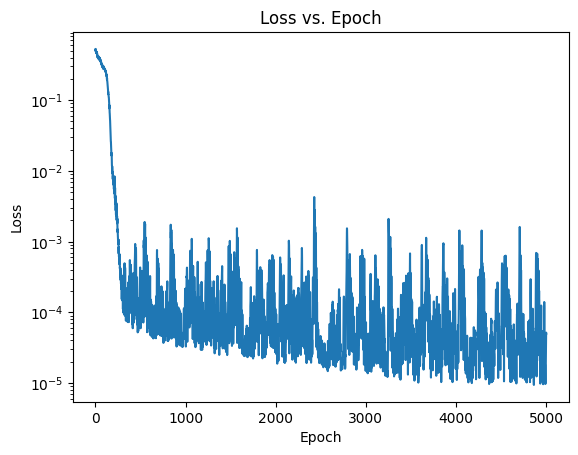

In [7]:
# Plot the loss history
plt.figure()
plt.plot(range(len(loss_history)), loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss vs. Epoch')
plt.show()

In [8]:
torch.save(model.state_dict(), "Burgers.pth")

In [9]:
# model = BurgersPINN(layers=layers, activation=activation)
# model.load_state_dict(torch.load("/work/Burgers.pth"))
# model.eval()

In [10]:
# Testing on the boundary
model.eval()

initial_preds = []
boundary_preds = []
correct_initial = []
correct_boundary = []

test_epochs = 1000

for i in range(test_epochs):
    initial_t, initial_x, initial_u, boundary_t, boundary_x, boundary_u = random_boundary(2, 0.5, t_range, x_range)
    initial_prediction = model(initial_t, initial_x)
    boundary_prediction = model(boundary_t, boundary_x)
    initial_preds.append(initial_prediction.item())
    boundary_preds.append(boundary_prediction.item())
    correct_initial.append(initial_u.item())
    correct_boundary.append(boundary_u.item())



/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


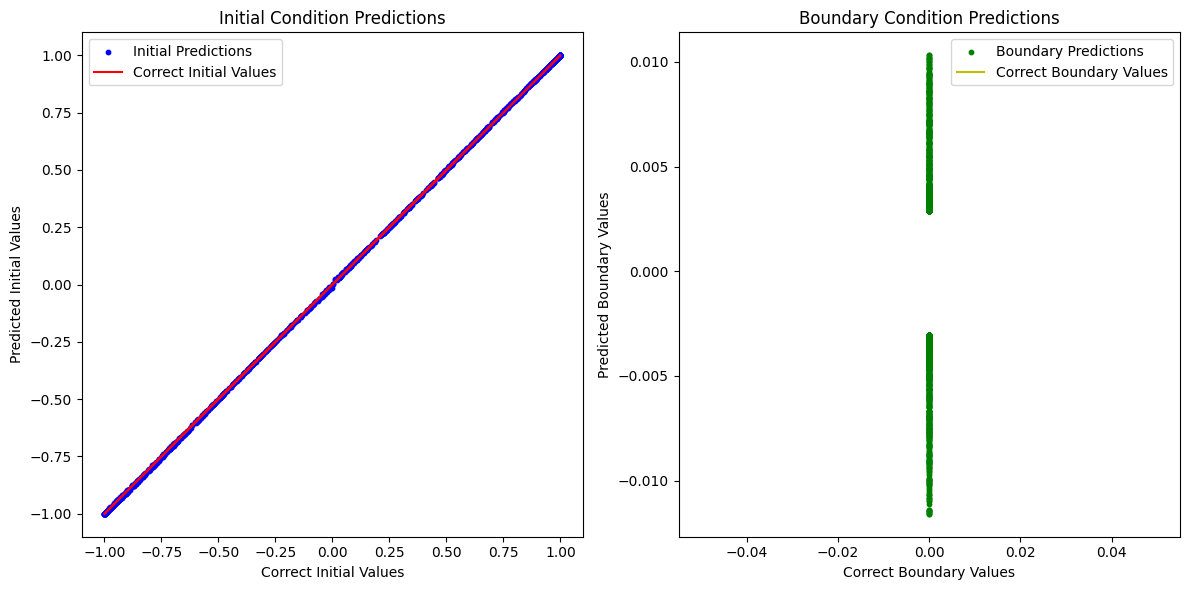

In [11]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(correct_initial, initial_preds, s=10, c='b', label='Initial Predictions')
plt.plot(correct_initial, correct_initial, c='r', label='Correct Initial Values')
plt.xlabel('Correct Initial Values')
plt.ylabel('Predicted Initial Values')
plt.title('Initial Condition Predictions')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(correct_boundary, boundary_preds, s=10, c='g', label='Boundary Predictions')
plt.plot(correct_boundary, correct_boundary, c='y', label='Correct Boundary Values')
plt.xlabel('Correct Boundary Values')
plt.ylabel('Predicted Boundary Values')
plt.title('Boundary Condition Predictions')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# Testing on the domain
model.eval()

residuals = []
test_epochs = 1000

for i in range(test_epochs):
    t, x = random_domain(1, t_range, x_range)
    prediction = model(t, x)
    residual = burgers_residual(prediction, t, x)
    residuals.append(residual.item())

TypeError: tensor() missing 1 required positional arguments: "data"

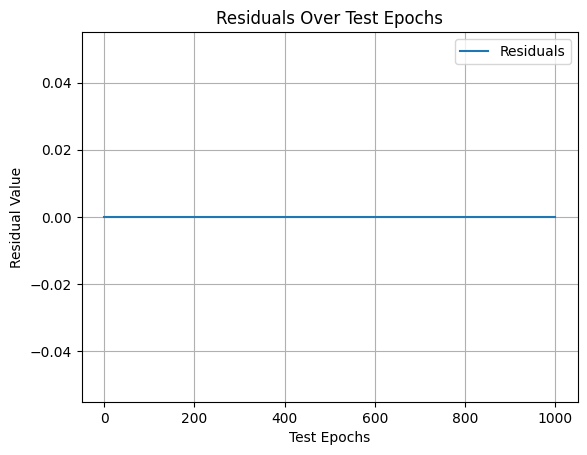

In [15]:
plt.plot(range(test_epochs), residuals, label='Residuals')
plt.xlabel('Test Epochs')
plt.ylabel('Residual Value')
plt.title('Residuals Over Test Epochs')
plt.legend()
plt.grid()

plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=10bedb5b-3713-4aa3-bd35-83eed005533b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>